In [225]:
# data manuipulation
import numpy as np
import pandas as pd

# modeling utilities
import scipy.stats as stats
from sklearn import metrics
from sklearn import preprocessing
from sklearn import  linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.feature_selection import RFECV

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from  sklearn import model_selection

import pydotplus
import graphviz
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import itertools
import time


# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sn
from pandas.plotting import scatter_matrix

In [226]:
df = pd.read_csv("HousePrice.csv")

In [227]:
print(df.head(5))
df.shape

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities    ...     PoolArea PoolQC Fence MiscFeature MiscVal  \
0         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
1         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
2         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
3         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
4         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  
0      2   2008     

(1460, 81)

In [228]:
print(df.SalePrice.describe())
print(df.MoSold.describe())

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64
count    1460.000000
mean        6.321918
std         2.703626
min         1.000000
25%         5.000000
50%         6.000000
75%         8.000000
max        12.000000
Name: MoSold, dtype: float64


In [229]:
get_ipython().magic('matplotlib inline')
sn.set_style('whitegrid')
sn.set_context('talk')
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (30, 10),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

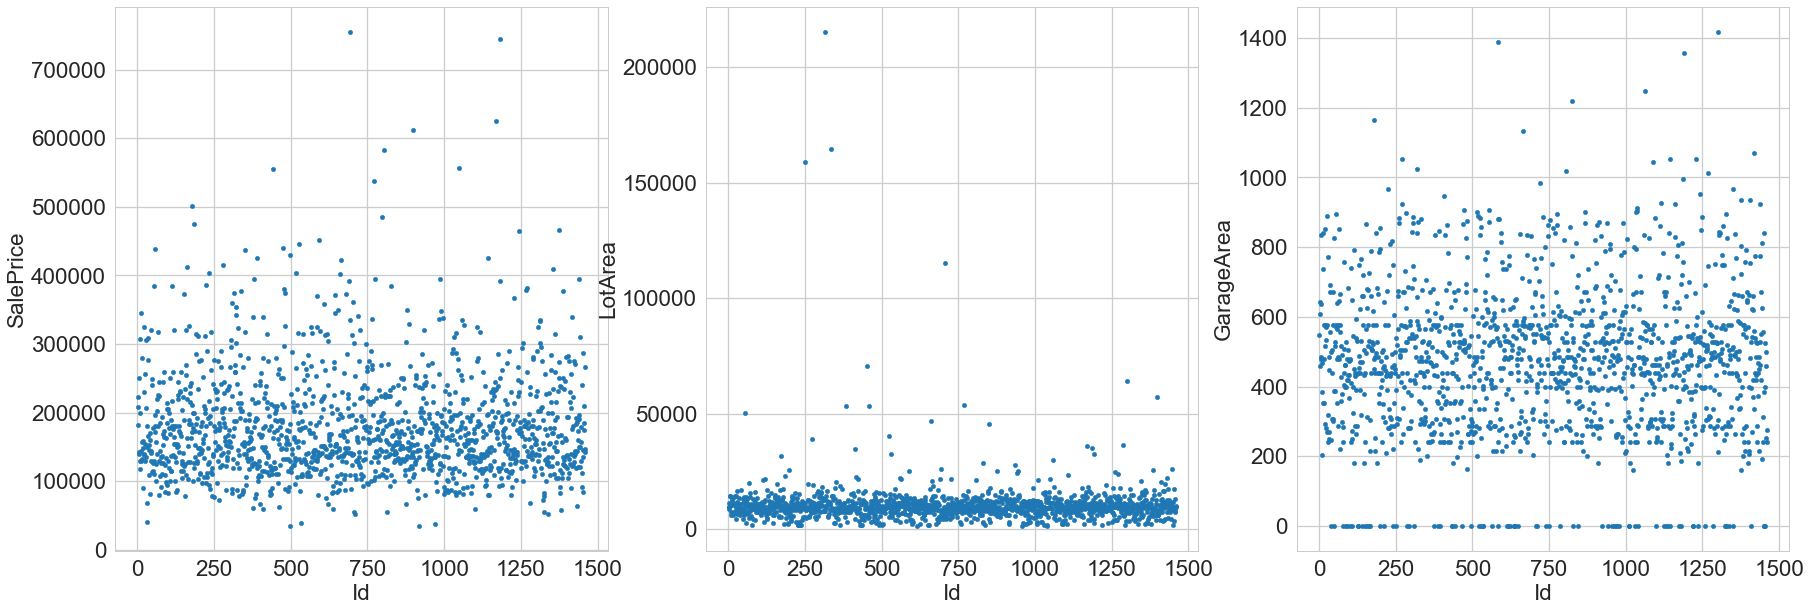

In [230]:
fig,((ax1,ax2,ax3))= plt.subplots(nrows=1,ncols=3)
df.plot(kind='scatter',x='Id',y='SalePrice',ax=ax1)
df.plot(kind='scatter',x='Id',y='LotArea',ax=ax2)
df.plot(kind='scatter',x='Id',y='GarageArea',ax=ax3)


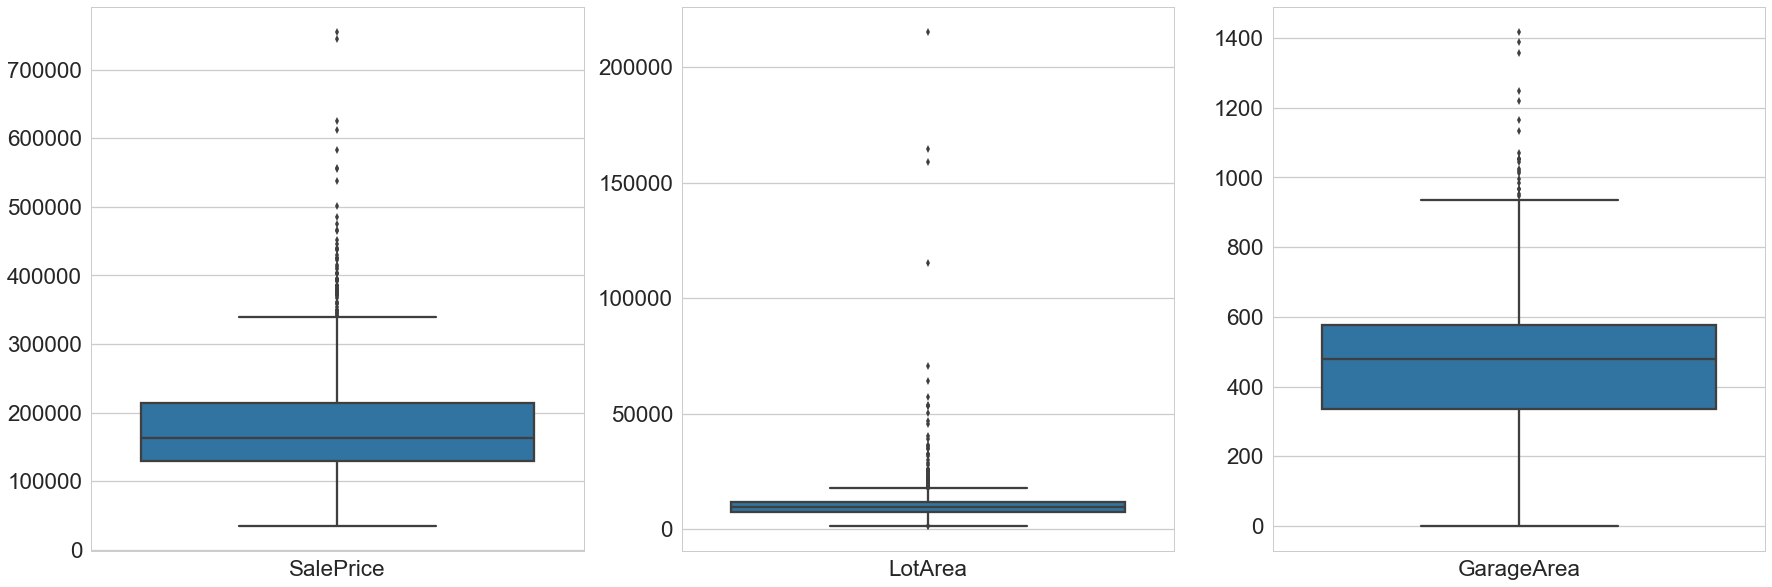

In [231]:
fig,(ax1,ax2,ax3)= plt.subplots(ncols=3)
sn.boxplot(data=df[['SalePrice']],ax=ax1)
sn.boxplot(data=df[['LotArea']],ax=ax2)
sn.boxplot(data=df[['GarageArea']],ax=ax3)


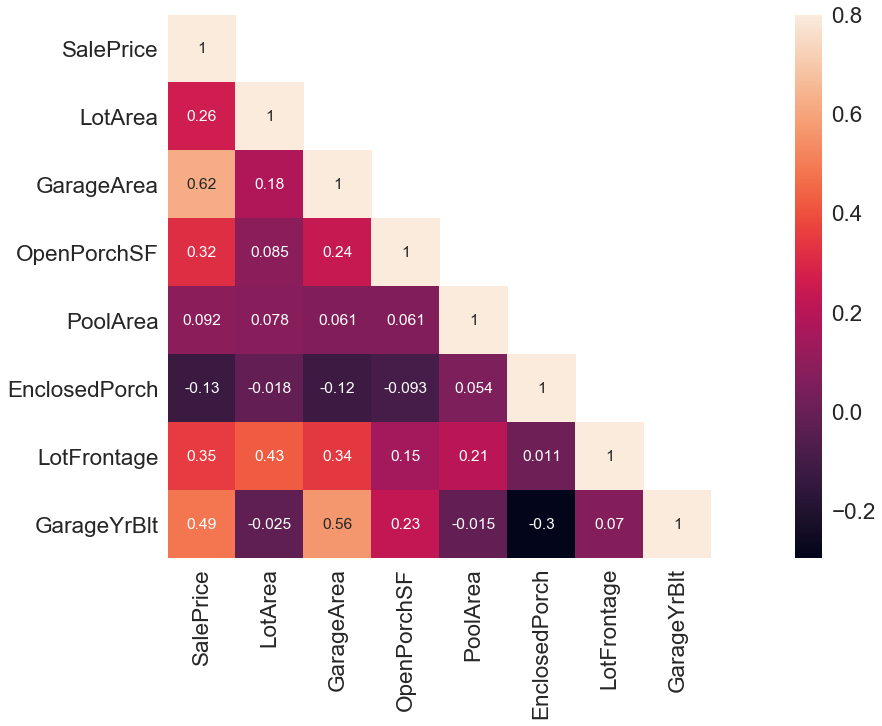

In [232]:
corrMatt = df[["SalePrice","LotArea",
               "GarageArea","OpenPorchSF",
               "PoolArea","EnclosedPorch","LotFrontage","GarageYrBlt" 
               ]].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
sn.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

In [233]:
df.shape
for column in df:
    if (df[column].isna().any()):
        print(column)
df = df.dropna(subset=['Electrical'])
df.LotFrontage.fillna(0, inplace = True)
#df.GarageYrBlt.fillna(0, inplace = True)

LotFrontage
Alley
MasVnrType
MasVnrArea
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Electrical
FireplaceQu
GarageType
GarageYrBlt
GarageFinish
GarageQual
GarageCond
PoolQC
Fence
MiscFeature


In [234]:
def remove_outliers(df, column):
    q1=int(df[column].quantile(0.25))
    q3 = int(df[column].quantile(0.75))
    iqr=q3-q1
    fence_high = q3+1.5*iqr
    fence_low = q1-1.5*iqr
    temp = []
    n = 0
    for row in df[column]:
        if (row < fence_low)|(row> fence_high):
            temp.append(n)
        n+=1
        #df.drop([row])  
    df = df.drop(temp)
    df = df.reset_index(drop='True')
    return df

In [235]:
df = remove_outliers(df, "SalePrice")
print(df.shape)
df = remove_outliers(df, "LotArea")
print(df.shape)
df = remove_outliers(df, "GarageArea")
print(df.shape)
df = remove_outliers(df, "GrLivArea")
print(df.shape)
"""for column in df:
    if (type(df[column][0]) is np.int64):
        df = remove_outliers(df, column)
        print(df.shape)"""

(1398, 81)
(1327, 81)
(1322, 81)
(1303, 81)


'for column in df:\n    if (type(df[column][0]) is np.int64):\n        df = remove_outliers(df, column)\n        print(df.shape)'

In [236]:
def compute_mode(numbers):
    counts = {}
    maxcount = 0
    num_maxcount = 0
    num_store = []
    g_list = [] #for working the 2nd max
    for number in numbers:
        if number not in counts:
            counts[number] = 0
            num_store.append(number)
        counts[number] += 1
        if counts[number] > maxcount:
            maxcount = counts[number]
    if maxcount ==1:
        return 0
    for number, count in counts.items():
        if count == maxcount:
            num_maxcount = number
    counts.pop(num_maxcount)
    for i in num_store:
        if (type(counts.get(i)) is int):
            g_list.append(counts.get(i))
    return (max(g_list))/maxcount

In [237]:
for column in df:
    if (compute_mode(df[column]) < 0.05):
        print(compute_mode(df[column]))
        df = df.drop(columns = column)

df.shape

0
0.002307692307692308
0.038619556285949055
0.0451505016722408
0.0007680491551459293
0.038338658146964855
0.0046439628482972135
0.0038669760247486465
0.010139416983523447
0.046232876712328765
0.027906976744186046
0.040998217468805706
0.0034542314335060447
0.01018808777429467
0.013175230566534914
0.00234009360374415
0.04838709677419355
0.027160493827160494
0.048295454545454544
0.04411764705882353
0.012589928057553957
0.001557632398753894
0.004152823920265781
0.0007686395080707148
0.0007686395080707148
0.035856573705179286
0.008750994431185362


(1303, 54)

In [238]:
## Sample the dataset and divide into two part: Training set 70% Testing set 30%
X, X_test, y, y_test = train_test_split(df.iloc[:,0:-1],df.iloc[:,-1],test_size=0.4,random_state=42)
X.reset_index(inplace=True)
y = y.reset_index()
X_test.reset_index(inplace=True)
temp = X_test
y_test = y_test.reset_index()
print("Training set::{}{}".format(X.shape,y.shape))
print("Testing set::{}".format(X_test.shape))
#y_test.isnull().any()

Training set::(781, 54)(781, 2)
Testing set::(522, 54)


In [239]:
# list the categorical variables
subset_cat_features = ['MSZoning','LotShape','LotConfig',
                 'Condition1','BldgType','HouseStyle','RoofStyle','Exterior1st','Exterior2nd',
                       'MasVnrType','ExterQual', 'ExterCond','Foundation','BsmtQual',
                       'BsmtExposure','BsmtFinType1','HeatingQC','CentralAir',
                'Electrical','KitchenQual','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond',
                 'PavedDrive','Fence','SaleType','SaleCondition']
# list the numerical variables
numeric_feature_cols =['MSSubClass','LotFrontage','LotArea','OverallQual','OverallCond','YearBuilt','YearRemodAdd',
                       'BsmtUnfSF','TotalBsmtSF','1stFlrSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath',
                      'HalfBath','BedroomAbvGr','TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars','GarageArea',
                      'MoSold','YrSold']

In [240]:
## define a function to transform the categorical variables
## encode Categoricals (Dummy Encoding) 

gen_dummy_features = pd.get_dummies(X[subset_cat_features], drop_first=True)
## Drop first n different kind, (n-1) dummy variables needed

gen_dummy_features.shape
print(X.shape)
print(X_test.shape)

(781, 54)
(522, 54)


In [241]:
### traing dataset
train_df_new = pd.concat([X[numeric_feature_cols],gen_dummy_features], axis=1)
print(X[numeric_feature_cols].shape)
print(gen_dummy_features.shape)
print("Shape::{}".format(train_df_new.shape))
print(train_df_new.shape)
train_df_new.GarageYrBlt.fillna(0, inplace = True)
qq = []
for column in train_df_new:
    qq.append(column)
len(qq)

(781, 23)
(781, 132)
Shape::(781, 155)
(781, 155)


155

In [242]:
### test dataset
print(X_test.shape)
gen_dummy_features_ = pd.get_dummies(X_test[subset_cat_features], drop_first=True)
print(gen_dummy_features_.shape)
test_df_new = pd.concat([X_test[numeric_feature_cols],gen_dummy_features_], axis=1)
print(test_df_new.shape)
print("Shape::{}".format(test_df_new.shape))
test_df_new.GarageYrBlt.fillna(0, inplace = True)
tt = []
for column in test_df_new:
    tt.append(column)
print(tt)

(522, 54)
(522, 132)
(522, 155)
Shape::(522, 155)
['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'MoSold', 'YrSold', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3', 'LotConfig_Inside', 'Condition1_Feedr', 'Condition1_Norm', 'Condition1_PosA', 'Condition1_PosN', 'Condition1_RRAe', 'Condition1_RRAn', 'Condition1_RRNn', 'BldgType_2fmCon', 'BldgType_Duplex', 'BldgType_Twnhs', 'BldgType_TwnhsE', 'HouseStyle_1.5Unf', 'HouseStyle_1Story', 'HouseStyle_2.5Fin', 'HouseStyle_2.5Unf', 'HouseStyle_2Story', 'HouseStyle_SFoyer', 'HouseStyle_SLvl', 'RoofStyle_Gable', 'RoofStyle_Gambrel', 'RoofStyle_Hip', 'RoofStyle_Mansard', 'Exterior1st_Asph

In [243]:

## Full model: linear regression
X_train = train_df_new
y_train = y.SalePrice.values.reshape(-1,1)
lin_reg = linear_model.LinearRegression()
# from sklearn import  linear_model
# http://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/modules/generated/sklearn.linear_model.LinearRegression.html
# call linear regression

In [244]:
X_train=X_train.astype(float)
# pd.astype 


In [245]:
# Train the model using the training sets
lin_reg.fit(X_train,y_train)
print(lin_reg.coef_)

[[ 3.45403545e+01  2.20705496e+01  2.12133501e+00  9.27386634e+03
   5.83292566e+03  3.17985660e+02  3.03164245e+01 -1.20895308e+01
   3.94261089e+01 -2.97455713e+01  7.06934103e+01  2.18824904e+03
  -3.24038938e+03 -2.62757733e+03 -2.30469609e+03 -3.60458931e+03
  -1.17135834e+03  4.07936930e+03 -2.88006560e+00  2.88454066e+03
   2.16083054e+01  3.06972889e+01 -5.50215628e+02  3.27178581e+04
   3.89586268e+04  2.08992557e+04  1.16939965e+04 -7.96763434e+02
   2.43022058e+02  8.99842408e+03 -4.66340492e+01  2.08192620e+03
   2.18100415e+03  4.43596620e+03  1.24930198e+04 -8.29564175e+02
   2.04431911e+04 -2.08619761e+04  1.53999770e+04  7.35769128e+03
   1.72536655e+04 -2.48059630e+04 -1.67441317e+04 -7.95343055e+03
  -5.67003819e+03  1.55906530e+04  6.82283644e+03 -5.04460824e+04
  -3.01609060e+03 -7.90115765e+03 -4.15021080e+03 -3.50608691e+03
   1.51544140e+04  3.81630192e+04  1.30748882e+04  2.17846673e+04
  -6.83669338e+04  2.14724730e+04 -8.59629736e+03 -1.17874061e+03
   4.30767

In [246]:
y_train = pd.DataFrame(y_train)
X_train2 = sm.add_constant(X_train, prepend=False)
# add the constant column for constant (sm.OLS)
# no need to add the constant column for constant (LinearRegression.fit())

In [247]:
## linear regression
reg = sm.OLS(y_train,X_train2).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      0   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     59.66
Date:                Mon, 15 Oct 2018   Prob (F-statistic):          1.87e-294
Time:                        12:24:22   Log-Likelihood:                -8597.8
No. Observations:                 781   AIC:                         1.750e+04
Df Residuals:                     629   BIC:                         1.821e+04
Df Model:                         151                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
MSSubClass               34.54

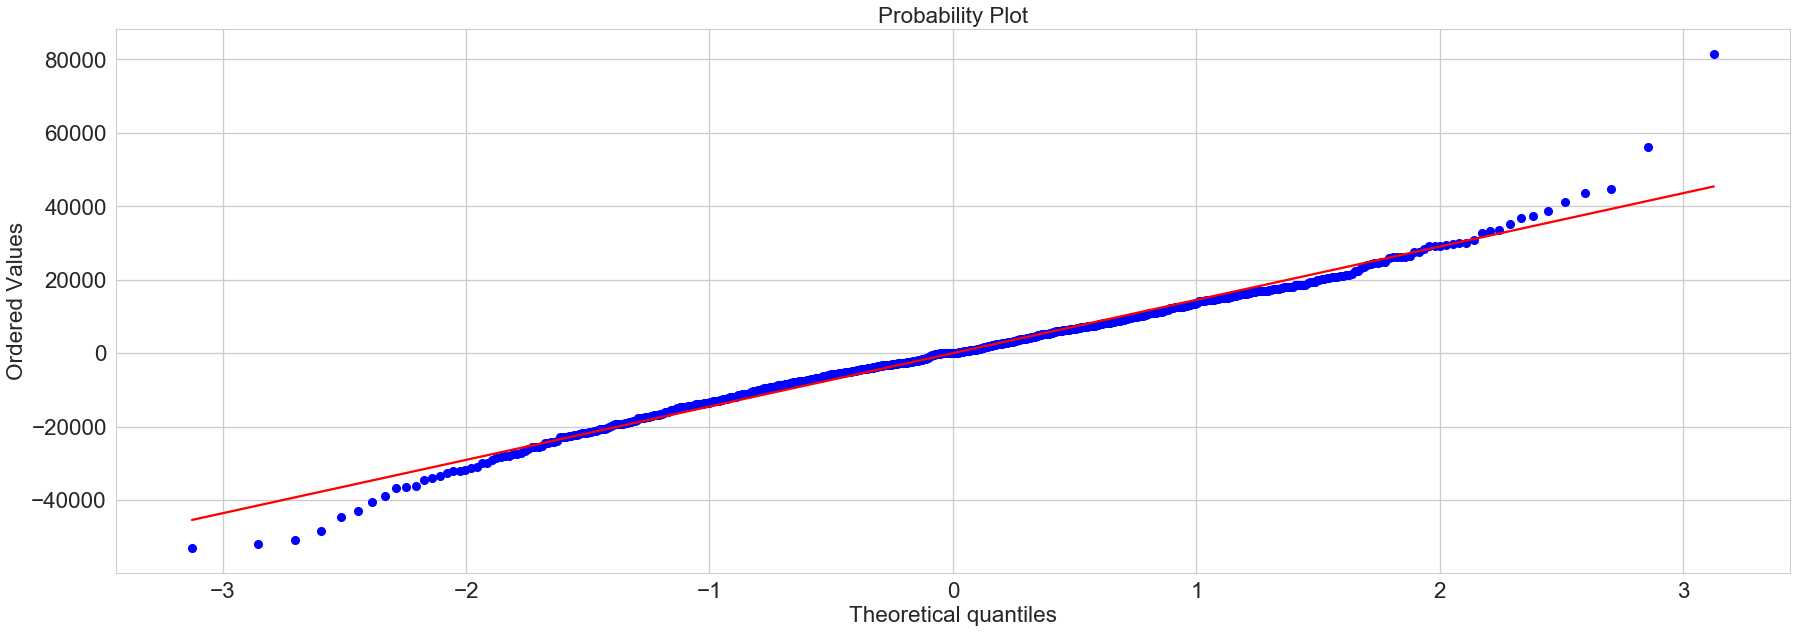

In [248]:
## Assumption checking - Normality Test(Q-Q Plot), using residual
stats.probplot(reg.resid, dist="norm", plot=plt)
plt.show()

(array([ 2.,  1.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,  1.,  0.,  3.,
         1.,  2.,  4.,  2.,  3.,  5.,  3.,  5.,  5.,  8.,  9.,  9.,  9.,
        13., 10., 14., 20., 15., 20., 17., 30., 23., 33., 38., 38., 16.,
        53., 24., 32., 25., 30., 36., 26., 23., 18., 18., 15., 23., 17.,
        15., 10.,  9.,  5.,  4.,  6.,  5.,  3.,  1.,  7.,  1.,  1.,  2.,
         1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-53021.44339943, -51675.729552  , -50330.01570457, -48984.30185714,
        -47638.58800971, -46292.87416228, -44947.16031485, -43601.44646742,
        -42255.73262   , -40910.01877257, -39564.30492514, -38218.59107771,
        -36872.87723028, -35527.16338285, -34181.44953542, -32835.73568799,
        -31490.02184056, -30144.30799314, -28798.59414571, -27452.88029828,
        -26107.16645085, -24761.45260342, -23415.73875

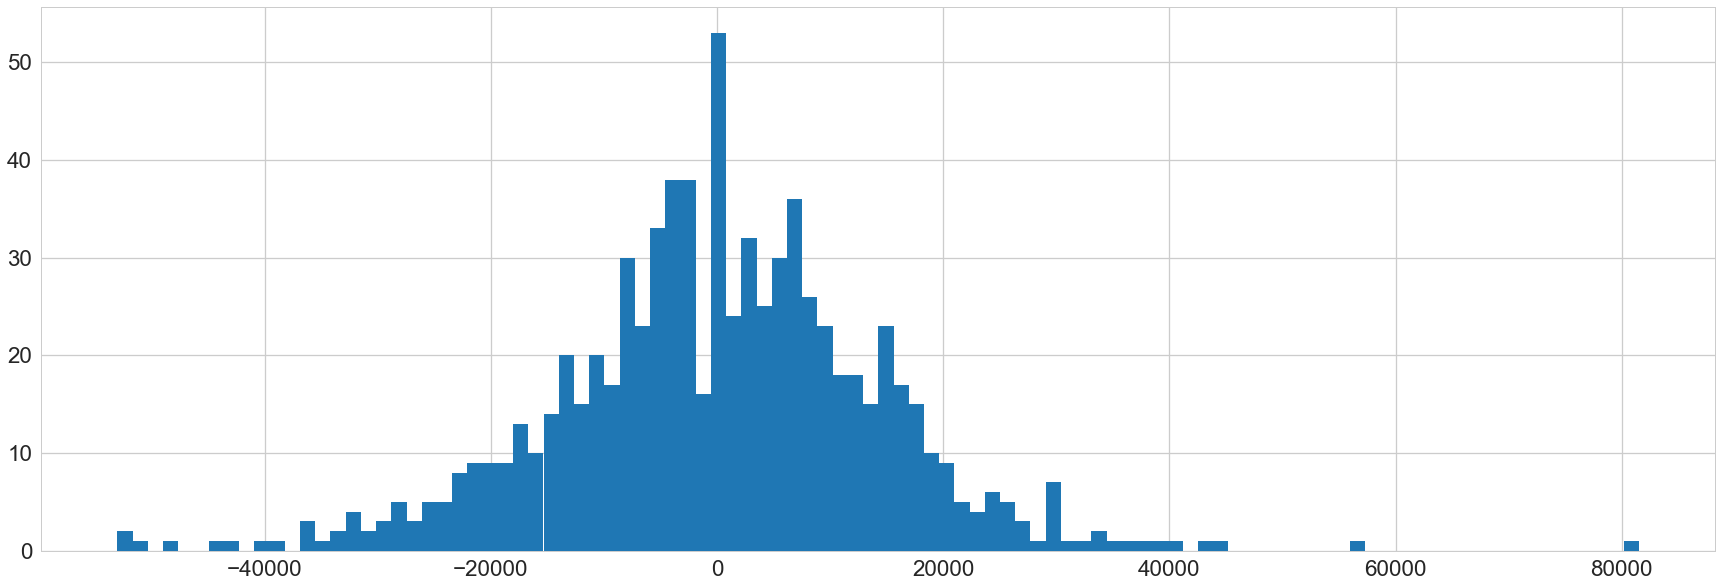

In [249]:
## Also use histogram to check the normality, using residual
plt.hist(reg.resid, 100)

Text(0,0.5,'residual')

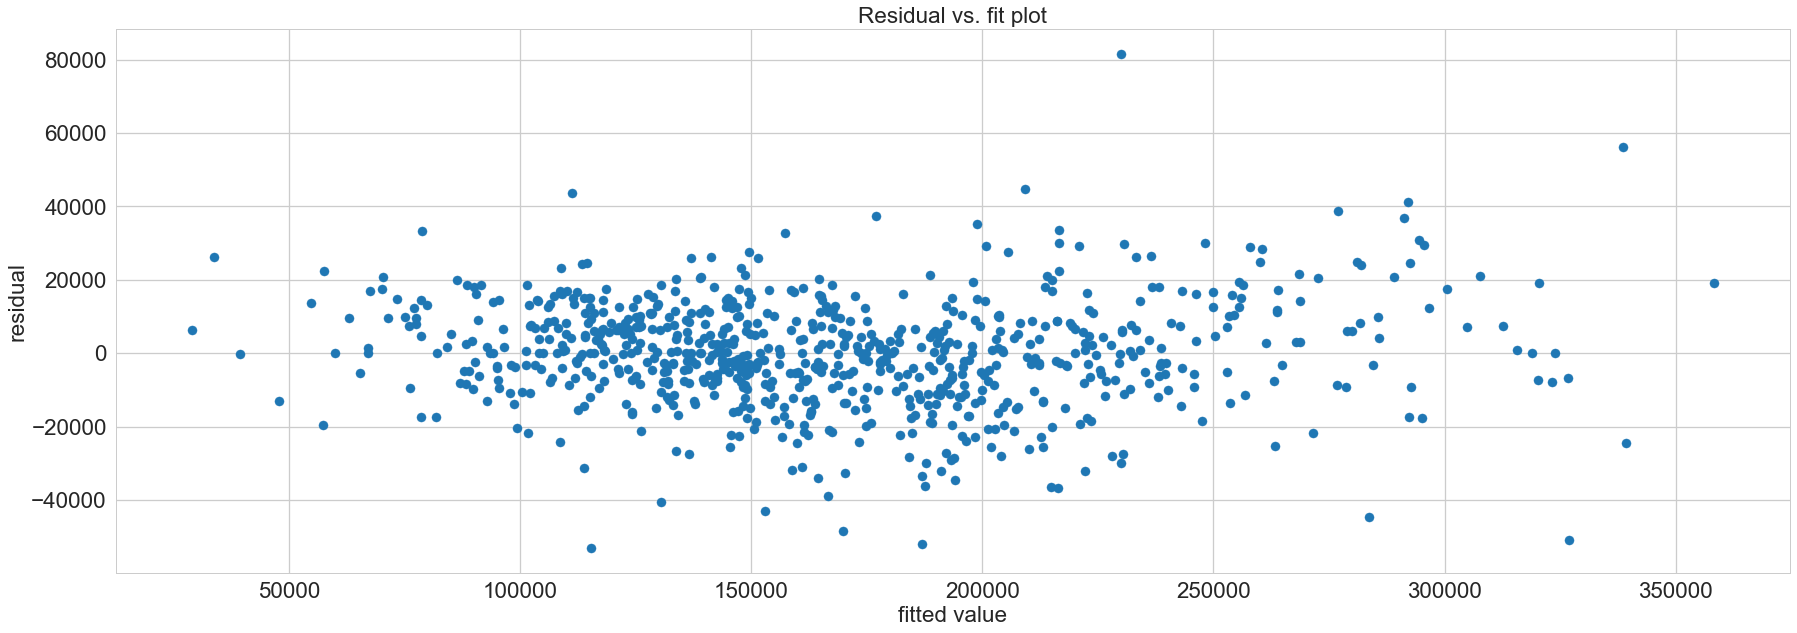

In [250]:
## Assumption checking - constant variance assumption and mean-zero assumption
# reg.resid, reg.fittedvalues
plt.scatter(reg.fittedvalues,reg.resid)
plt.title("Residual vs. fit plot")
plt.xlabel("fitted value")
plt.ylabel("residual")

Text(0,0.5,'residual')

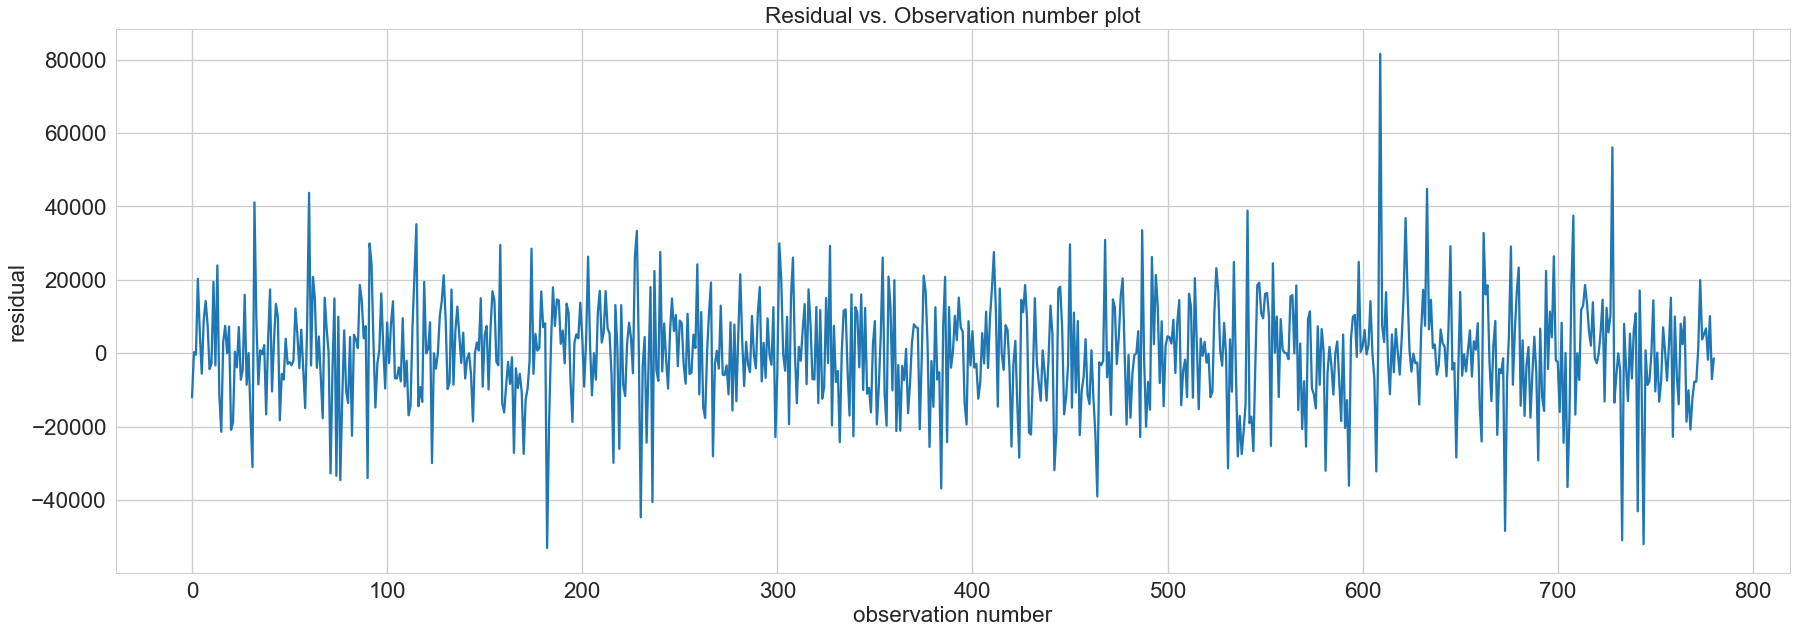

In [251]:
## Assumption checking - constant variance assumption and mean-zero assumption
plt.plot(reg.resid, '-')  # solid line
plt.title("Residual vs. Observation number plot")
plt.xlabel("observation number")
plt.ylabel("residual")

In [252]:
X_train.shape[1]

155

In [253]:
## Assumption checking - Check for multicolinearity
## Correlation matrix between the predictors - correlational matrix
## 
# For each Xi, calculate VIF
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
# X_train.shape[1] refers to the column number
vif["features"] = X_train.columns
n = 0
jj = []
print(vif.round(1))
for column in vif:
    for row in vif[column]:
        if row >10:
            jj.append(n)
        n+=1
    break
X_train_vif = X_train.copy()
X_train_vif.drop(vif.features[jj],axis=1,inplace=True)
X_train_vif.shape
            

/Users/clayton/anaconda3/lib/python3.6/site-packages/statsmodels/stats/outliers_influence.py:181: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


       VIF Factor               features
0    8.810000e+01             MSSubClass
1    6.900000e+00            LotFrontage
2    3.120000e+01                LotArea
3    1.103000e+02            OverallQual
4    6.850000e+01            OverallCond
5    5.606030e+04              YearBuilt
6    3.277210e+04           YearRemodAdd
7    1.570000e+01              BsmtUnfSF
8    8.310000e+01            TotalBsmtSF
9    2.362000e+02               1stFlrSF
10   2.630000e+02              GrLivArea
11   4.600000e+00           BsmtFullBath
12   1.600000e+00           BsmtHalfBath
13   4.030000e+01               FullBath
14   5.000000e+00               HalfBath
15   4.960000e+01           BedroomAbvGr
16   1.218000e+02           TotRmsAbvGrd
17   1.390000e+01             Fireplaces
18   1.964100e+03            GarageYrBlt
19   5.940000e+01             GarageCars
20   5.030000e+01             GarageArea
21   8.500000e+00                 MoSold
22   7.723320e+04                 YrSold
23   1.050000e+0

(781, 68)

In [254]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train_vif.values, i) for i in range(X_train_vif.shape[1])]
vif["features"] = X_train_vif.columns
vif.round(1)

,VIF Factor,features
0,4.7,LotFrontage
1,2.6,BsmtFullBath
2,1.3,BsmtHalfBath
3,1.9,HalfBath
4,6.2,MoSold
5,1.1,MSZoning_RH
6,1.2,LotShape_IR2
7,3.7,LotShape_Reg
8,1.5,LotConfig_CulDSac
9,1.3,LotConfig_FR2


In [255]:
## using the k-fold cross validation (specifically 10-fold) to reduce overfitting affects
# cross_val_predict function returns cross validated prediction values as fitted by the model object.
# predicted = cross_val_predict(lin_reg, X_train, y_train, cv=10)
predicted = cross_val_predict(lin_reg, X_train2, y_train, cv=10)

In [256]:
## calculate the cross validation scores and plot them
r2_scores = cross_val_score(lin_reg, X_train2, y_train, cv=10)
mse_scores = cross_val_score(lin_reg, X_train2, y_train, cv=10,scoring='neg_mean_squared_error')
print("R-squared::{}".format(r2_scores))
print("MSE::{}".format(mse_scores))

R-squared::[0.83869019 0.89584488 0.87690437 0.90515084 0.85851839 0.89351658
 0.90680312 0.88852891 0.86013305 0.59141092]
MSE::[-5.38590868e+08 -3.34952688e+08 -4.17308526e+08 -2.53162223e+08
 -3.40340108e+08 -4.01765763e+08 -3.56476797e+08 -4.94167702e+08
 -3.13868488e+08 -1.30463090e+09]


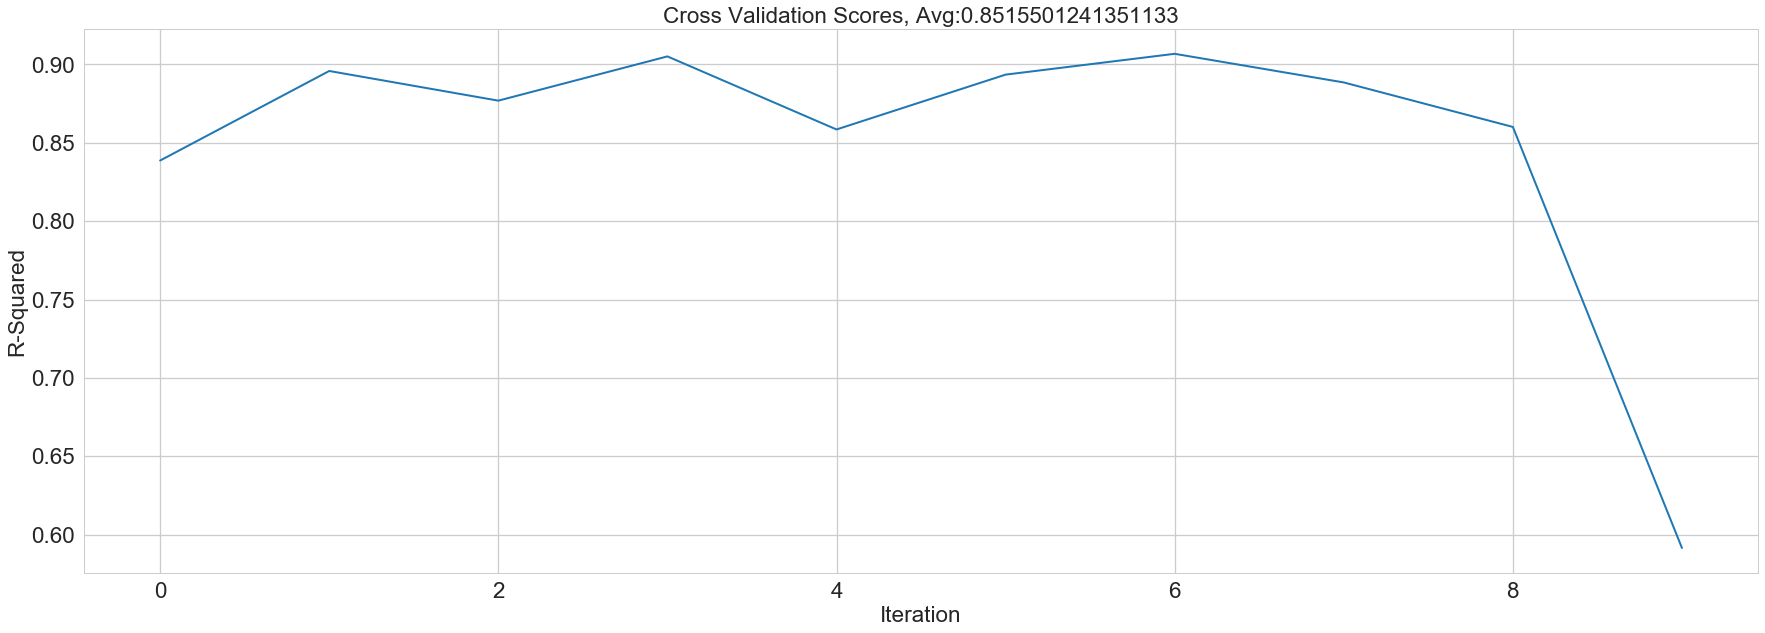

In [257]:
fig, ax = plt.subplots()
ax.plot([i for i in range(len(r2_scores))],r2_scores,lw=2)
ax.set_xlabel('Iteration')
ax.set_ylabel('R-Squared')
ax.title.set_text("Cross Validation Scores, Avg:{}".format(np.average(r2_scores)))
plt.show()

In [258]:
## test dataset
test_df_new.GarageYrBlt.fillna(0, inplace = True)
X_test = test_df_new
y_test = y_test.SalePrice.values.reshape(-1,1)
y_pred = lin_reg.predict(X_test)
residuals = y_test-y_pred

In [259]:
# X_test=X_test.astype(float)
r2_score = lin_reg.score(X_test,y_test)
print("R-squared::{}".format(r2_score))
print("MSE: %.2f" % metrics.mean_squared_error(y_test, y_pred))

R-squared::-0.4323229100298804
MSE: 4977343738.90


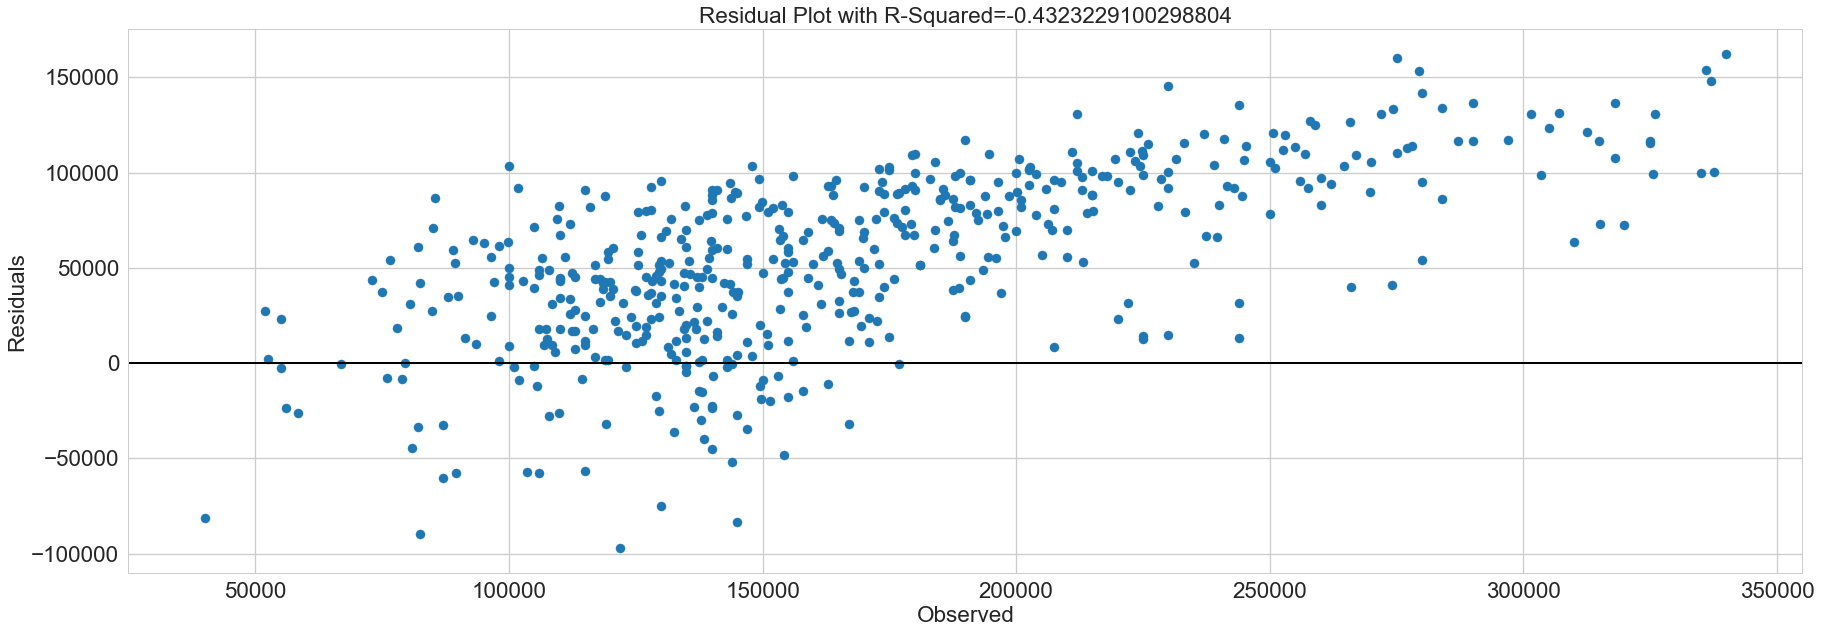

In [260]:
fig, ax = plt.subplots()
ax.scatter(y_test, residuals)
ax.axhline(lw=2,color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residuals')
ax.title.set_text("Residual Plot with R-Squared={}".format(np.average(r2_score)))
plt.show()

In [261]:
print("MSE: {}".format(metrics.mean_squared_error(y_test, y_pred)))

MSE: 4977343738.901133


In [262]:
df2 = X_train.copy()
df2['total_count']=y_train
df2.to_csv('clean.csv',index=False)

In [263]:
## Model after forward selection
def processSubset(feature_set):
    # Fit model on feature_set and calculate AIC
    X_select = X_train[list(feature_set)]
    X = sm.add_constant(X_select, prepend=False)
    model = sm.OLS(y_train,X)
    regr = model.fit()
    aic = regr.aic
    return {"model":regr, "AIC":aic, "predict":feature_set}

In [264]:
def getBest(k):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(X_train.columns, k):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the lowest AIC
    best_model = models.loc[models['AIC'].argmin()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [265]:
def forward(predictors):
    
    if 'const' in predictors:
        predictors.remove('const')
    
    
    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X_train.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    aic=[]
    name=[]
    predict=[]
    for i in range(len(results)):
        aic.append(results[i]['AIC'])
        name.append(results[i]['model'])
        predict.append(results[i]['predict'])
        
    
    models['AIC']=aic
    models['model']=name
    models['predict']=predict
    
    # Choose the model with the lowest AIC
    best_model = models.loc[models['AIC'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [266]:
models_fwd = pd.DataFrame(columns=["AIC", "model","predict"])

tic = time.time()
predictors = []

for i in range(1,len(X_train.columns)+1):    
    models_fwd.loc[i] = forward(predictors)
    predictors = models_fwd.loc[i]["model"].model.exog_names

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

/Users/clayton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Processed  155 models on 1 predictors in 0.6043879985809326 seconds.
Processed  154 models on 2 predictors in 0.6493771076202393 seconds.
Processed  153 models on 3 predictors in 0.5839121341705322 seconds.
Processed  152 models on 4 predictors in 0.6701610088348389 seconds.
Processed  151 models on 5 predictors in 0.6646969318389893 seconds.
Processed  150 models on 6 predictors in 0.6127688884735107 seconds.
Processed  149 models on 7 predictors in 0.7287359237670898 seconds.
Processed  148 models on 8 predictors in 0.6244900226593018 seconds.
Processed  147 models on 9 predictors in 0.7143199443817139 seconds.
Processed  146 models on 10 predictors in 0.7129678726196289 seconds.
Processed  145 models on 11 predictors in 0.5916149616241455 seconds.
Processed  144 models on 12 predictors in 0.6472840309143066 seconds.
Processed  143 models on 13 predictors in 0.6102440357208252 seconds.
Processed  142 models on 14 predictors in 0.6611661911010742 seconds.
Processed  141 models on 15 p

In [267]:
models_fwd

,AIC,model,predict
1,18519.677652,<statsmodels.regression.linear_model.Regressio...,[OverallQual]
2,18308.986885,<statsmodels.regression.linear_model.Regressio...,"[OverallQual, GrLivArea]"
3,18149.454259,<statsmodels.regression.linear_model.Regressio...,"[OverallQual, GrLivArea, TotalBsmtSF]"
4,18021.626997,<statsmodels.regression.linear_model.Regressio...,"[OverallQual, GrLivArea, TotalBsmtSF, YearBuilt]"
5,17947.057332,<statsmodels.regression.linear_model.Regressio...,"[OverallQual, GrLivArea, TotalBsmtSF, YearBuil..."
6,17887.488144,<statsmodels.regression.linear_model.Regressio...,"[OverallQual, GrLivArea, TotalBsmtSF, YearBuil..."
7,17828.863427,<statsmodels.regression.linear_model.Regressio...,"[OverallQual, GrLivArea, TotalBsmtSF, YearBuil..."
8,17797.688834,<statsmodels.regression.linear_model.Regressio...,"[OverallQual, GrLivArea, TotalBsmtSF, YearBuil..."
9,17756.374947,<statsmodels.regression.linear_model.Regressio...,"[OverallQual, GrLivArea, TotalBsmtSF, YearBuil..."
10,17717.204186,<statsmodels.regression.linear_model.Regressio...,"[OverallQual, GrLivArea, TotalBsmtSF, YearBuil..."


In [268]:
## select the best model
index = models_fwd['AIC'].idxmin()
predictor = models_fwd.loc[index, 'predict']
print(predictor)

['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'YearBuilt', 'LotArea', 'BsmtUnfSF', 'KitchenQual_TA', 'OverallCond', 'KitchenQual_Gd', 'BedroomAbvGr', 'GarageArea', 'FireplaceQu_Gd', 'Foundation_PConc', 'Condition1_RRAe', 'BsmtExposure_Gd', 'KitchenQual_Fa', 'MSZoning_RM', 'BsmtQual_Gd', 'BsmtQual_TA', 'BldgType_Duplex', 'BsmtQual_Fa', 'MSZoning_FV', 'BsmtFinType1_GLQ', 'Exterior1st_BrkComm', 'Exterior1st_BrkFace', '1stFlrSF', 'MSSubClass', 'Fireplaces', 'LotConfig_CulDSac', 'Exterior2nd_Plywood', 'Exterior2nd_HdBoard', 'GarageYrBlt', 'Condition1_Norm', 'HouseStyle_2.5Fin', 'Exterior2nd_Other', 'SaleType_CWD', 'BsmtFullBath', 'RoofStyle_Gambrel', 'ExterQual_TA', 'Condition1_PosN', 'Condition1_RRAn', 'ExterQual_Gd', 'SaleType_Con', 'MSZoning_RH', 'MSZoning_RL', 'MasVnrType_Stone', 'HouseStyle_1.5Unf', 'BsmtFinType1_LwQ', 'BldgType_TwnhsE', 'Exterior2nd_Stone', 'FireplaceQu_Fa', 'GarageQual_Po', 'ExterCond_Fa', 'ExterQual_Fa', 'HouseStyle_2Story', 'MasVnrType_BrkFace', 'MasVnrType_None', 'S

In [269]:
## see the model after selection
X_train3 = X_train[predictor]
X_train3 = sm.add_constant(X_train3, prepend=False)
reg_selection = sm.OLS(y_train,X_train3).fit()
print(reg_selection.summary())

                            OLS Regression Results                            
Dep. Variable:                      0   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     135.1
Date:                Mon, 15 Oct 2018   Prob (F-statistic):               0.00
Time:                        12:27:07   Log-Likelihood:                -8618.7
No. Observations:                 781   AIC:                         1.738e+04
Df Residuals:                     709   BIC:                         1.772e+04
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
OverallQual            8645.34

In [270]:
## For the model selected by stepwise selection, 
## using the k-fold cross validation (specifically 10-fold) to reduce overfitting affects
# cross_val_predict function returns cross validated prediction values as fitted by the model object.
# predicted = cross_val_predict(lin_reg, X_train, y_train, cv=10)
lin_reg_s = linear_model.LinearRegression()
lin_reg_s = lin_reg_s.fit(X_train3, y_train)
predicted = cross_val_predict(lin_reg_s, X_train3, y_train, cv=10)

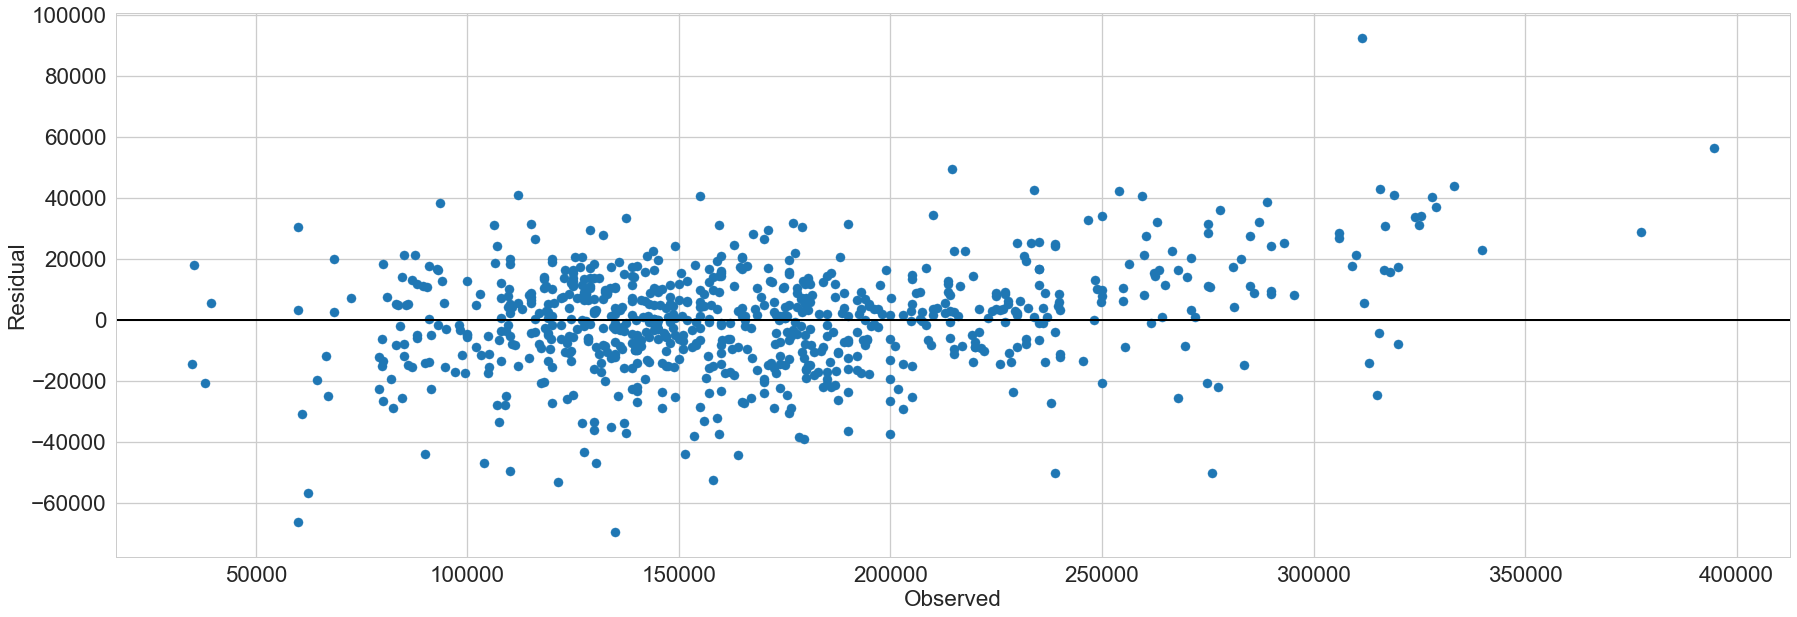

In [271]:
## Assumption checking - check of homoscedasticity
## residual plot
fig, ax = plt.subplots()
ax.scatter(y_train, y_train-predicted)
ax.axhline(lw=2,color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residual')
plt.show()

In [272]:
## calculate the cross validation scores and plot them
r2_scores = cross_val_score(lin_reg_s, X_train3, y_train, cv=10)
mse_scores = cross_val_score(lin_reg_s, X_train3, y_train, cv=10,scoring='neg_mean_squared_error')
print("R-squared::{}".format(r2_scores))
print("MSE::{}".format(mse_scores))

R-squared::[0.91718003 0.90306468 0.90201172 0.92361804 0.90341071 0.91637761
 0.9226189  0.91331443 0.88867838 0.88561678]
MSE::[-2.76524270e+08 -3.11734501e+08 -3.32191681e+08 -2.03871347e+08
 -2.32349700e+08 -3.15510262e+08 -2.95981653e+08 -3.84289848e+08
 -2.49811333e+08 -3.65227306e+08]


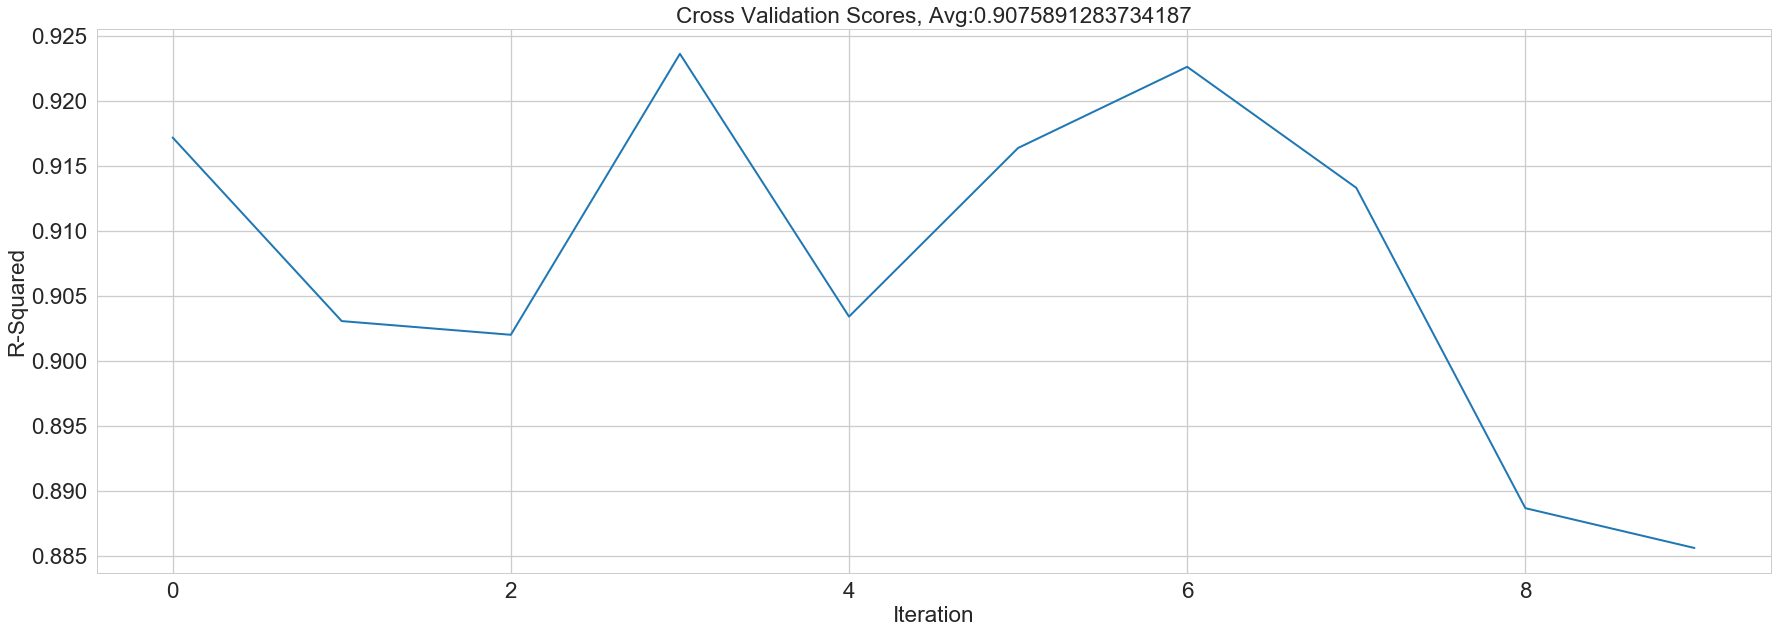

In [273]:
fig, ax = plt.subplots()
ax.plot([i for i in range(len(r2_scores))],r2_scores,lw=2)
ax.set_xlabel('Iteration')
ax.set_ylabel('R-Squared')
ax.title.set_text("Cross Validation Scores, Avg:{}".format(np.average(r2_scores)))
plt.show()

In [274]:
## test dataset
X_test=X_test.astype(float)
#have to do this if the program dont work !!!!!!!!!!
predictor.remove('Exterior2nd_Other')
predictor.remove('SaleType_CWD')

print(set(predictor)-set(X_test))
X_test2 = X_test[predictor]
lin_reg_s_test = linear_model.LinearRegression()
lin_reg_s_test = lin_reg_s.fit(X_test2, y_test)
# y_test = y_test.total_count.values.reshape(-1,1)
y_test = pd.DataFrame(y_test)
y_pred = lin_reg_s_test.predict(X_test2)
y_pred = pd.DataFrame(y_pred)
residuals = y_test-y_pred

set()


In [275]:
r2_score = lin_reg_s_test.score(X_test2,y_test)
print("R-squared::{}".format(r2_score))
print("MSE: %.2f" % metrics.mean_squared_error(y_test, y_pred))

R-squared::0.9191909268479831
MSE: 280812749.33


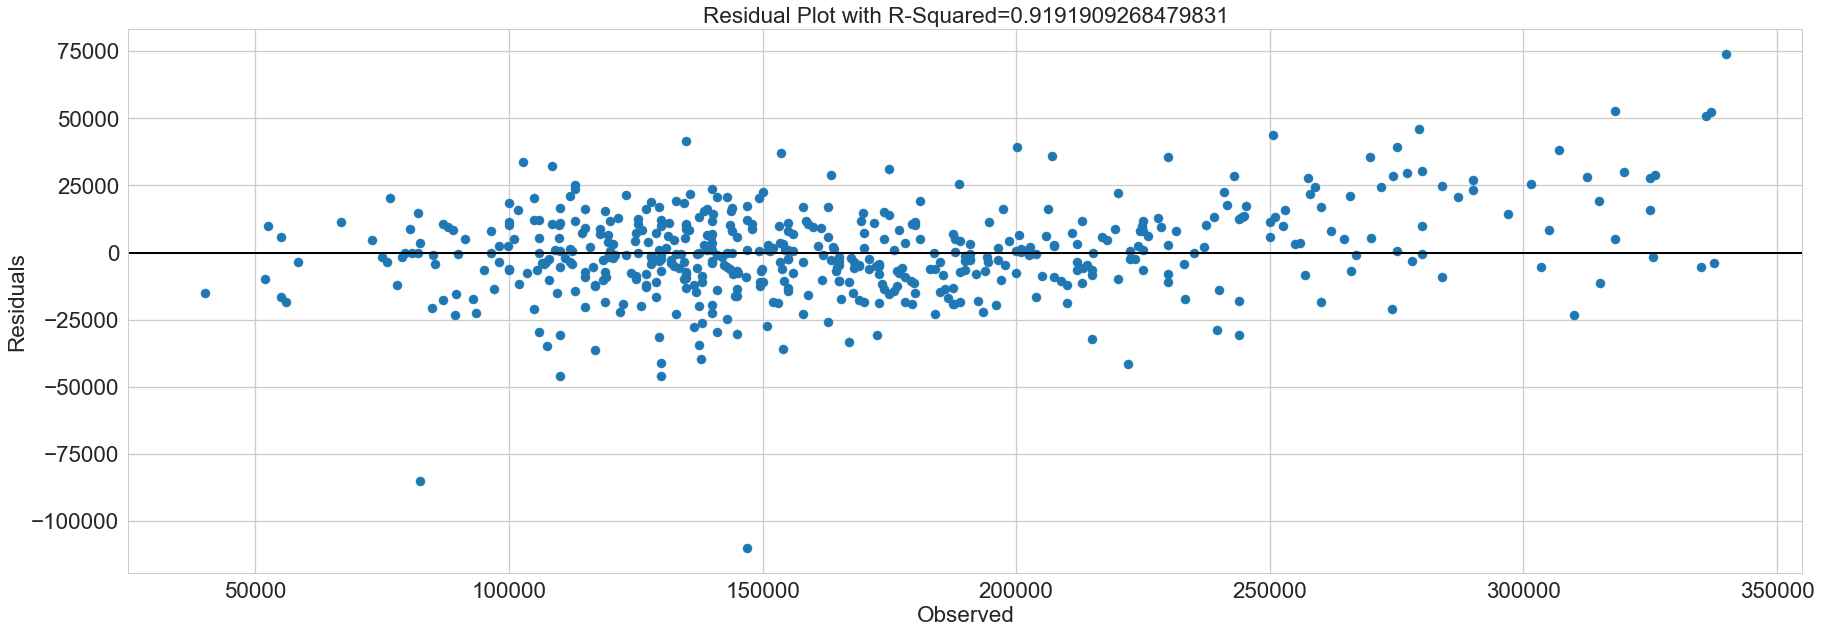

In [276]:
fig, ax = plt.subplots()
ax.scatter(y_test, residuals)
ax.axhline(lw=2,color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residuals')
ax.title.set_text("Residual Plot with R-Squared={}".format(np.average(r2_score)))
plt.show()

In [277]:
print("MSE: {}".format(metrics.mean_squared_error(y_test, y_pred)))

MSE: 280812749.33402


In [278]:
## for test dataset
X_test_vif = X_test2.copy()

In [279]:
vif2 = pd.DataFrame()
vif2["VIF Factor"] = [variance_inflation_factor(X_test_vif.values, i) for i in range(X_test_vif.shape[1])]
vif2["features"] = X_test_vif.columns
vif2.round(1)

,VIF Factor,features
0,91.4,OverallQual
1,119.4,GrLivArea
2,41.5,TotalBsmtSF
3,698.5,YearBuilt
4,28.7,LotArea
5,8.3,BsmtUnfSF
6,27.7,KitchenQual_TA
7,39.4,OverallCond
8,15.8,KitchenQual_Gd
9,37.1,BedroomAbvGr


In [280]:
#regreesion tree

In [281]:
# list the categorical variables
cat_attr_list = ['MSZoning','LotShape','LotConfig',
                 'Condition1','BldgType','HouseStyle','RoofStyle','Exterior1st','Exterior2nd','MasVnrType','ExterQual',
                'ExterCond','Foundation','BsmtQual','BsmtExposure','BsmtFinType1','HeatingQC','CentralAir',
                'Electrical','KitchenQual','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond',
                 'PavedDrive','Fence','SaleType','SaleCondition','MSSubClass','OverallQual',
                 'OverallCond','YearBuilt','YearRemodAdd',
                 'BsmtFullBath','BsmtHalfBath','FullBath',
                      'HalfBath','BedroomAbvGr','TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars',
                      'MoSold','YrSold']

In [282]:
## Decision tree based regression

gen_dummy_features_tree = pd.get_dummies(X[subset_cat_features])
train_df_new_tree = pd.concat([X[numeric_feature_cols],gen_dummy_features_tree], axis=1)
dtr = DecisionTreeRegressor(max_depth=5)
train_df_new_tree.GarageYrBlt.fillna(0, inplace = True)
dtr.fit(train_df_new_tree,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [283]:
dtr.score(train_df_new_tree,y_train)

0.8672322429288236

In [284]:
gen_dummy_features_tree = pd.get_dummies(temp[subset_cat_features])
test_tree = pd.concat([temp[numeric_feature_cols],gen_dummy_features_tree], axis=1)
test_tree.GarageYrBlt.fillna(0, inplace = True)

In [285]:
## display the tree
from IPython.display import Image  
dot_data = export_graphviz(dtr, out_file=None, 
                         feature_names=train_df_new_tree.columns,
                         class_names=y_train.columns,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
graph.write_pdf("ii.pdf") 

True

In [286]:
y_pred = dtr.predict(test_tree)

In [287]:
print("MSE::{}".format(mean_squared_error(y_test, y_pred)))

MSE::1076289083.5039792


In [288]:
def plot_feature_importances(feature_importances, title, feature_names):
    # Normalize the importance values 
    feature_importances = 100.0 * (feature_importances / max(feature_importances))

    # Sort the values and flip them
    index_sorted = np.flipud(np.argsort(feature_importances))

    # Arrange the X ticks
    pos = np.arange(index_sorted.shape[0]) + 0.5

    # Plot the bar graph
    plt.figure()
    plt.bar(pos, feature_importances[index_sorted], align='center')
    plt.xticks(pos, feature_names[index_sorted])
    plt.ylabel('Relative Importance')
    plt.title(title)
    plt.show()  

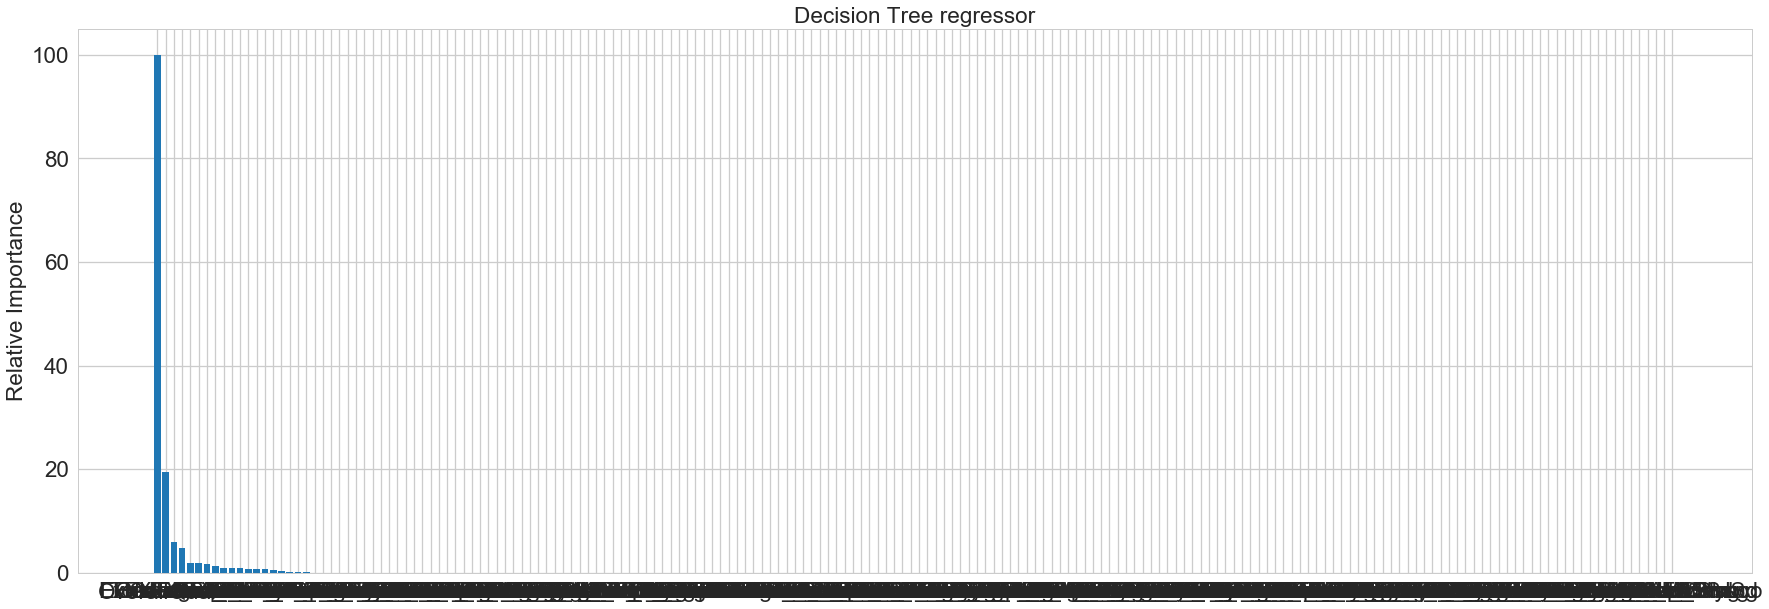

In [289]:
plot_feature_importances(dtr.feature_importances_,'Decision Tree regressor', train_tree.columns)